#Connect To Drive

In [1]:
from google.colab import drive
drive.mount("/content/gdrive")


Mounted at /content/gdrive


In [2]:
%cd /content/gdrive/MyDrive/coding

/content/gdrive/MyDrive/coding


#Data Split

In [3]:
from sklearn.model_selection import train_test_split
import os
import shutil

In [ ]:
#Split dataset path
folder_path = '/content/gdrive/MyDrive/your_path/dataset' #Change "your_path" with your real path
os.makedirs(folder_path, exist_ok=True)

#Origin dataset path
data_path = '/content/gdrive/MyDrive/your_path/dataset' 
class_folders = [f for f in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, f))]

# Split the data into training and validation sets for each class
for class_folder in class_folders:
    class_path = os.path.join(data_path, class_folder)

    # List all images in the class folder
    images = [f for f in os.listdir(class_path) if f.endswith('.jpg') or f.endswith('.png')]  # Adjust file extensions as needed

    # Split the images for training and validation
    train_images, val_images = train_test_split(images, test_size=0.4, random_state=42)

    # Create folders for training and validation in the target folder path
    train_class_path = os.path.join(folder_path, 'train', class_folder)
    val_class_path = os.path.join(folder_path, 'val', class_folder)

    os.makedirs(train_class_path, exist_ok=True)
    os.makedirs(val_class_path, exist_ok=True)

    # Copy training images
    for img in train_images:
        src_path = os.path.join(class_path, img)
        dst_path = os.path.join(train_class_path, img)
        shutil.copy(src_path, dst_path)

    # Copy validation images
    for img in val_images:
        src_path = os.path.join(class_path, img)
        dst_path = os.path.join(val_class_path, img)
        shutil.copy(src_path, dst_path)

#Main Content

In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import callbacks
from tensorflow.keras.preprocessing import image
from google.colab import files
import numpy as np
import matplotlib.pyplot as plt
import time
from IPython.display import Image, display

In [14]:
#Setting Environment
base_dir = "/content/gdrive/MyDrive/your_path/dataset/"
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")

imgW, imgH = 150, 100
batch_size = 32
lr = 0.001
epoch = 100
num_classes = 3
name_classes = ['scissors', 'rock', 'paper']

In [6]:
#Data Augmentation
train_datagen = ImageDataGenerator(
    rescale = 1.0/255,
    horizontal_flip = True,
    brightness_range = [0.8, 1.2],
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    fill_mode = "nearest"
)
validation_datagen = ImageDataGenerator(
    rescale = 1.0/255
)

In [7]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (imgW, imgH),
    batch_size = batch_size,
    class_mode = 'categorical',  #Categorical for Multiclass
    classes = name_classes,
    shuffle = True
)

validation_generator = validation_datagen.flow_from_directory(
    val_dir,
    target_size = (imgW, imgH),
    batch_size = batch_size,
    class_mode = 'categorical',
    classes = name_classes,
    shuffle = False
)

Found 1314 images belonging to 3 classes.
Found 874 images belonging to 3 classes.


In [8]:
model = Sequential()
#Layer1
model.add(Conv2D(32, (3, 3), input_shape=(imgW, imgH, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

#Layer2
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

#Layer3
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

#Flatten Layer
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(3, activation='softmax'))

In [10]:
model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=lr),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [ ]:
start_time = time.time()

history = model.fit(
    train_generator,
    steps_per_epoch=9,
    epochs=epoch,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)
model.save(f"/content/gdrive/MyDrive/your_path/M{epoch}E.h5")

end_time = time.time()
duration_s = end_time - start_time
duration_m = duration_s/60
print(f"Training completed \nTraining duration: {duration_s} seconds --> {duration_m} minutes")


Epoch 1/100
9/9 [==============================] - 7s 880ms/step - loss: 0.0973 - accuracy: 0.9722 - val_loss: 0.0502 - val_accuracy: 0.9861
Epoch 2/100
9/9 [==============================] - 7s 844ms/step - loss: 0.1083 - accuracy: 0.9653 - val_loss: 0.1091 - val_accuracy: 0.9641
Epoch 3/100
9/9 [==============================] - 7s 877ms/step - loss: 0.1936 - accuracy: 0.9271 - val_loss: 0.0403 - val_accuracy: 0.9896
Epoch 4/100
9/9 [==============================] - 5s 642ms/step - loss: 0.1870 - accuracy: 0.9306 - val_loss: 0.0770 - val_accuracy: 0.9757
Epoch 5/100
9/9 [==============================] - 6s 667ms/step - loss: 0.2586 - accuracy: 0.9070 - val_loss: 0.0556 - val_accuracy: 0.9861
Epoch 6/100
9/9 [==============================] - 5s 648ms/step - loss: 0.2042 - accuracy: 0.9410 - val_loss: 0.0706 - val_accuracy: 0.9780
Epoch 7/100
9/9 [==============================] - 8s 946ms/step - loss: 0.1419 - accuracy: 0.9535 - val_loss: 0.0711 - val_accuracy: 0.9780
Epoch 8/100
9

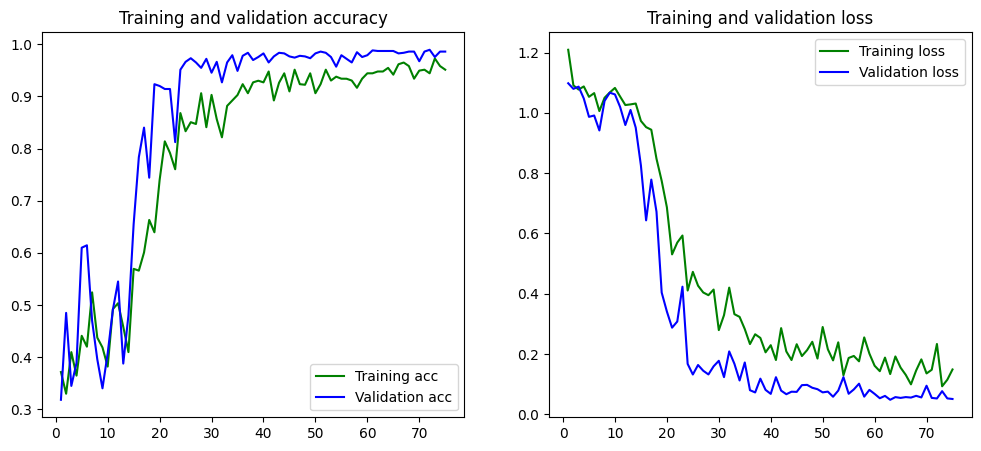

In [12]:
def plot_training_history(history):
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    epochs = range(1, len(acc) + 1)

    #Plot accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, "g", label="Training acc")
    plt.plot(epochs, val_acc, "b", label="Validation acc")
    plt.title("Training and validation accuracy")
    plt.legend()

    #Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, "g", label="Training loss")
    plt.plot(epochs, val_loss, "b", label="Validation loss")
    plt.title("Training and validation loss")
    plt.legend()

    plt.savefig(f"/content/gdrive/MyDrive/your_path/M{epoch}E.png")

    plt.show()

plot_training_history(history)

Saving 01dM3ewPIsnBICu1.png to 01dM3ewPIsnBICu1 (1).png
1/1 [==============================] - 0s 28ms/step


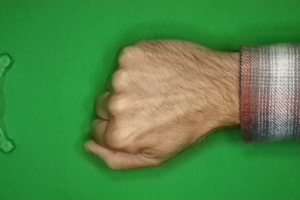

Predicted Class: rock
Predicted Probabilities: [[0.00205285 0.97577083 0.02217632]]


In [ ]:
#Upload
uploaded = files.upload()
img_path = list(uploaded.keys())[0]

#Image preprocessing for matching to the model
img = image.load_img(img_path, target_size=(imgW, imgH))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0

#Predict
predictions = model.predict(img_array)
class_labels = name_classes

#Result
display(Image(filename=img_path))
predicted_class = class_labels[np.argmax(predictions)]
print("Predicted Class:", predicted_class)
print("Predicted Probabilities:", predictions)
